## Detecting Twitter Bots

In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score,recall_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
import itertools
import collections
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import csv
import nltk
from nltk import FreqDist
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy
from pprint import pprint 
from sklearn.ensemble import VotingClassifier
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
warnings.filterwarnings("ignore")  
%matplotlib inline

In [43]:
filepath = '/Users/devanshibhatia/Desktop/BOTDETECTION/'
file= filepath+'training_data_2_csv_UTF.csv'

training_data = pd.read_csv(file)
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]


### Exploratory Data Analysis



#### Identifying Missingness in the data

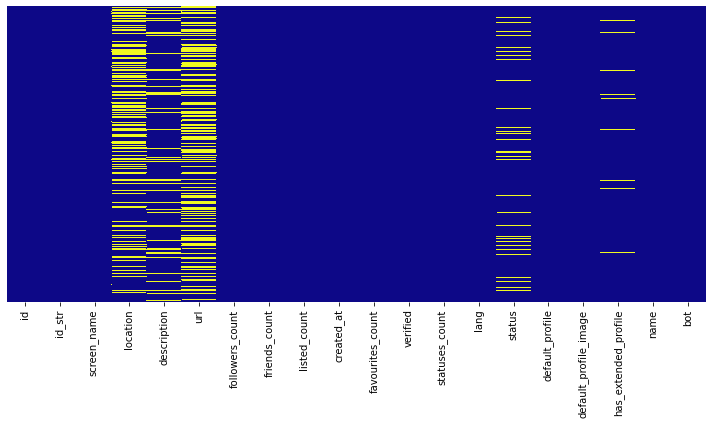

In [44]:
def get_heatmap(df):
    #This function gives heatmap of all NaN values
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='plasma')
    plt.tight_layout()
    return plt.show()

get_heatmap(training_data)

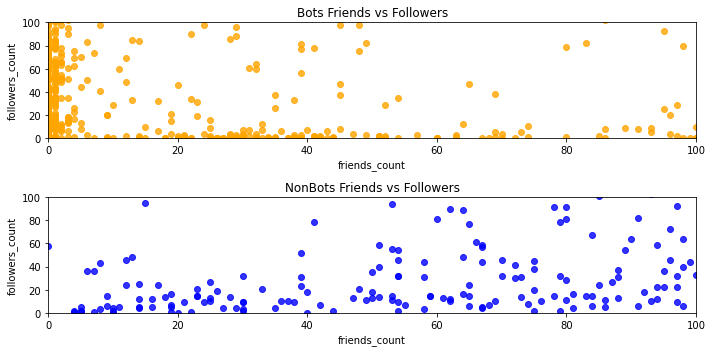

In [45]:
bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(bots.friends_count, bots.followers_count, color='orange', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('NonBots Friends vs Followers')
sns.regplot(nonbots.friends_count, nonbots.followers_count, color='blue', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

#### Identifying Imbalance in the data

In [46]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(952, 21)

(504, 21)


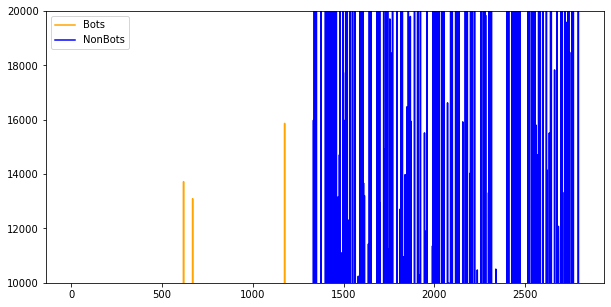

In [47]:
plt.figure(figsize=(10,5))
plt.plot(bots.listed_count, color='orange', label='Bots')
plt.plot(nonbots.listed_count, color='blue', label='NonBots')
plt.legend(loc='upper left')
plt.ylim(10000,20000)
print(bots[(bots.listed_count<5)].shape)

In [48]:
bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

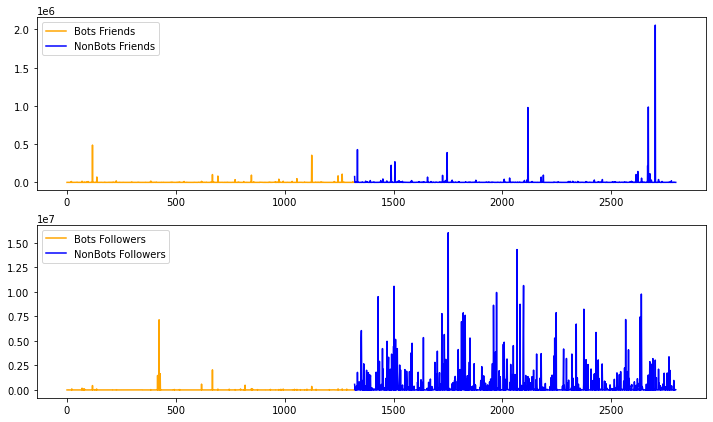

In [49]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='orange', label='Bots Friends')
plt.plot(nonbots_listed_count_df.friends_count, color='blue', label='NonBots Friends')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='orange', label='Bots Followers')
plt.plot(nonbots_listed_count_df.followers_count, color='blue', label='NonBots Followers')
plt.legend(loc='upper left')

In [50]:
#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binary'] = (bots.location.isnull())
bots['verified_binary'] = (bots.verified==False)
bots.shape

(1321, 24)

In [51]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
nonbots['location_binary'] = (nonbots.location.isnull()==False)
nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(1476, 24)

In [52]:
df = pd.concat([bots, nonbots])
df.shape

(2797, 24)

### Feature Independence using Spearman correlation

In [53]:
df.corr(method='spearman')

,id,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,bot,friends_by_followers,screen_name_binary,location_binary,verified_binary
id,1.000000,-0.672925,-0.402346,-0.615005,-0.439430,-0.611899,-0.451945,0.522990,0.166601,0.652131,0.270435,-0.576100,-0.228328,0.150100
followers_count,-0.672925,1.000000,0.375522,0.896126,0.457363,0.709732,0.649117,-0.496899,-0.293838,-0.468430,-0.577157,0.458213,0.189675,0.130717
friends_count,-0.402346,0.375522,1.000000,0.204403,0.641529,0.356452,0.111118,-0.296358,-0.097607,-0.483105,0.427638,0.342145,0.082692,-0.210592
listed_count,-0.615005,0.896126,0.204403,1.000000,0.349059,0.694340,0.684976,-0.447376,-0.269035,-0.318445,-0.681034,0.338698,0.188797,0.281360
favourites_count,-0.439430,0.457363,0.641529,0.349059,1.000000,0.394227,0.295108,-0.348043,-0.226956,-0.526228,0.104797,0.408864,0.120941,-0.220894
verified,-0.611899,0.709732,0.356452,0.694340,0.394227,1.000000,0.333278,-0.404650,-0.132298,-0.508555,-0.419815,0.434177,0.191922,0.346505
statuses_count,-0.451945,0.649117,0.111118,0.684976,0.295108,0.333278,1.000000,-0.375918,-0.289999,-0.089018,-0.533971,0.162213,0.105333,0.207384
default_profile,0.522990,-0.496899,-0.296358,-0.447376,-0.348043,-0.404650,-0.375918,1.000000,0.246979,0.407748,0.197929,-0.377572,-0.138378,0.072351
default_profile_image,0.166601,-0.293838,-0.097607,-0.269035,-0.226956,-0.132298,-0.289999,0.246979,1.000000,0.139669,0.190986,-0.166388,0.000596,0.033021
bot,0.652131,-0.468430,-0.483105,-0.318445,-0.526228,-0.508555,-0.089018,0.407748,0.139669,1.000000,-0.044056,-0.843429,-0.266342,0.606771


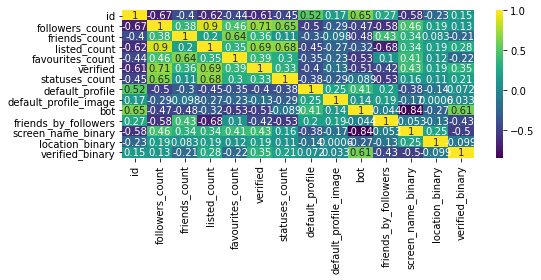

In [54]:
plt.figure(figsize=(8,4))
sns.heatmap(df.corr(method='spearman'), cmap='viridis', annot=True)
plt.tight_layout()
plt.show()

Result:
- There is no correlation between **id, statuses_count, default_profile, default_profile_image** and target variable.
- There is strong correlation between **verified, listed_count, friends_count, followers_count** and target variable.
- We cannot perform correlation for categorical attributes. So we will take **screen_name, name, description, status** into feature engineering. While use **verified, listed_count** for feature extraction.

#### Performing Feature Engineering

#### Performing Feature Extraction

## Implementing Different Models

#### Decision Tree Classifier

In [55]:
def remove_stopwords(rev):
    rev_new =[]
    for sentence in rev:
        for word in sentence:
            #rev_new_word = []
            if word not in stop_words:
                rev_new.append(word)
        #rev_new.append(rev_new_word)
    return rev_new
    #rev_new = " ".join([i for i in rev if i not in stop_words])
   # return rev_new

In [56]:
tweets_data = []
x = []
y = []
dataset = []
all_words = []
vectorizer = CountVectorizer(stop_words='english')

def retrieveProcessedData(Pdata_url,row_num):
    with open(Pdata_url, 'r', encoding="latin-1") as csvfile:
        csvreader = csv.reader(csvfile)
        c = 0
        for row in csvreader:
            #replace characters
            if row[19] == '0':
                continue
            y = row[row_num]
            if(len(y)==0):
                continue
            if(c==1):
                print(y)
            c = c+1
            if(c == 10000):
                break
            y = re.sub('[^A-Za-z0-9 ]+', '', y)
            y = y.replace("@", "")
            y = y.replace("n\'t", " not")
            #remove links
            y = re.sub(r"http\S+", "", y)
            #remove words less than 2
            y = re.sub(r'\b\b', '', y)
            #Lowercase
            y = y.lower()
            x.append(y)
        
        #remove_stopwords(x)   
          

In [57]:
# function to plot most frequent terms
def freq_words(x, terms = 50):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  #dash = dict(sorted(words_df.items(), key=lambda item: item[1]))
  #dash = sorted(words_df.items(), key=lambda x: x[1], reverse=True)
 # print(words_df)
  #sorted_dict = collections.OrderedDict(words_df)
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  
  bag_array = d['word'].to_numpy()
  #print(bag_array)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()
  return bag_array
    

In [58]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    #print(output)
    return output

In [59]:
def preprocessing():
    tokenized_reviews = pd.Series(x).apply(lambda t: t.split())
    reviews = lemmatization(tokenized_reviews)
    reviews_3 = []
    for i in range(len(reviews)):
        reviews_3.append(' '.join(reviews[i]))
    dataset = reviews_3
    bag_array = []
    bag_array = freq_words(dataset, 20)
   # print(bag_array)
    s = ''
    for ele in bag_description :
        s += ele
        s += '|'
    s = s[:-1] 
    return s

In [60]:
nlp = spacy.load("en", disable=['parser', 'ner'])

"HoustonPokeMap"


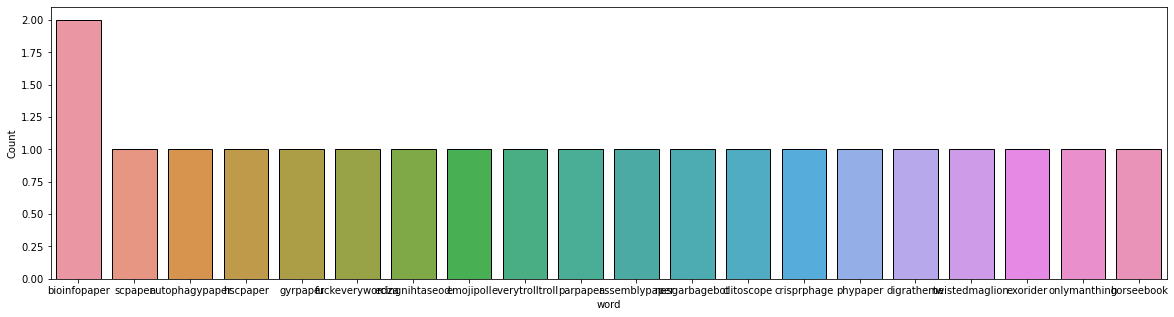

"Rare and strong PokÅ½mon in Houston, TX. See more PokÅ½mon at https://t.co/dnWuDbFRkt"


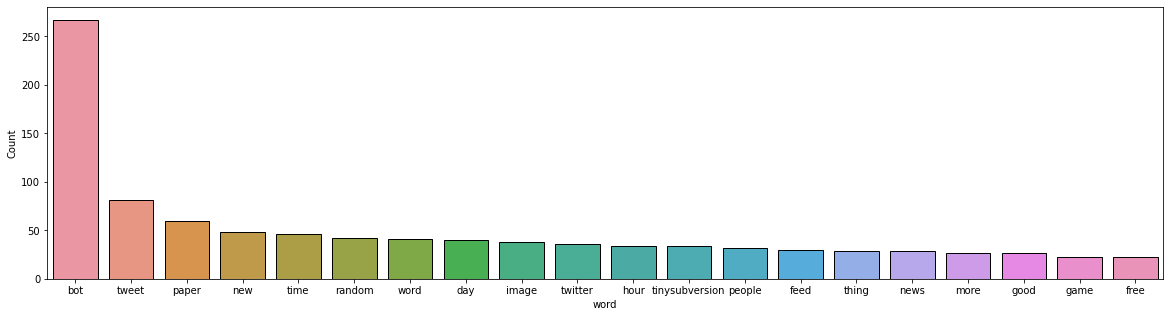

{
      "created_at": "Sun Mar 12 15:44:04 +0000 2017",
      "id": 840951532543737900,
      "id_str": "840951532543737856",
      "text": "[Southeast Houston] Chansey (F) (IV: 73%) until 11:11:37AM at 2511 Winbern St https://t.co/HYRIyq4mF7 https://t.co/bydOOKsEEI",
      "truncated": false,
      "entities":  {
        "hashtags":  [],
        "symbols":  [],
        "user_mentions":  [],
        "urls":  [
           {
            "url": "https://t.co/HYRIyq4mF7",
            "expanded_url": "https://houstonpokemap.com/#29.73067033,-95.36610821",
            "display_url": "houstonpokemap.com/#29.73067033,-Ã",
            "indices":  [
              78,
              101
            ]
          },
           {
            "url": "https://t.co/bydOOKsEEI",
            "expanded_url": "https://maps.google.com/maps?q=29.73067033,-95.36610821",
            "display_url": "maps.google.com/maps?q=29.7306Ã",
            "indices":  [
              102,
              125
            ]
  

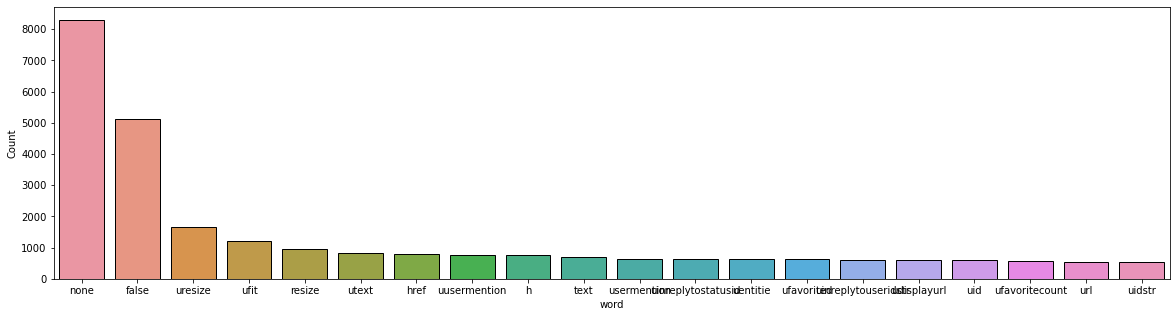

"Houston PokÅ½ Alert"


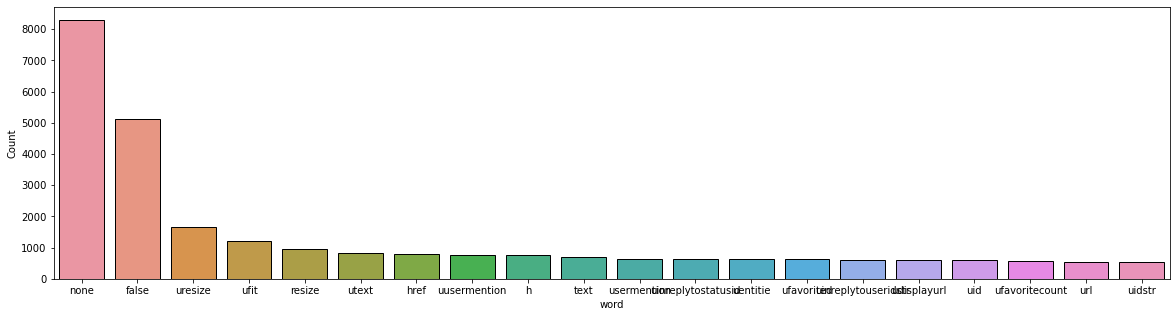

In [61]:
bag_description = [] #4
bag_screen_name = [] #2
bag_name = [] #18
bag_status = [] #14

#s = ''

def runall():
    # retrieveTweet('data/tweetdata.txt')
   
    retrieveProcessedData('/Users/devanshibhatia/Desktop/PROJECT/FINALPROJECT/FinalProjectAndCode/kaggle_data/training_data_2_csv_UTF.csv',2)
    s = preprocessing()
    #print("this is s :", s)
    training_data['screen_name_binary'] = training_data.description.str.contains(s, case=False, na=False)
    
    
    retrieveProcessedData('/Users/devanshibhatia/Desktop/PROJECT/FINALPROJECT/FinalProjectAndCode/kaggle_data/training_data_2_csv_UTF.csv',4)
    s = preprocessing()
    #print("description s", s)
    training_data['description_binary'] = training_data.description.str.contains(s, case=False, na=False)
    
    retrieveProcessedData('/Users/devanshibhatia/Desktop/PROJECT/FINALPROJECT/FinalProjectAndCode/kaggle_data/training_data_2_csv_UTF.csv',14)
    s = preprocessing()
    training_data['status_binary'] = training_data.description.str.contains(s, case=False, na=False)
    
    retrieveProcessedData('/Users/devanshibhatia/Desktop/PROJECT/FINALPROJECT/FinalProjectAndCode/kaggle_data/training_data_2_csv_UTF.csv',18)
    
    # remove stopwords from the text
    #data = [remove_stopwords(r.split()) for r in x]
    # make entire text lowercase
    #data = [r.lower() for r in data]
    s = preprocessing()
    training_data['name_binary'] = training_data.description.str.contains(s, case=False, na=False)
runall()

In [88]:
training_data['screen_name_binary']
training_data['name_binary']
training_data['description_binary']
training_data['status_binary']

0        True
1        True
2        True
3       False
4        True
        ...  
2792     True
2793     True
2794     True
2795     True
2796     True
Name: status_binary, Length: 2797, dtype: bool

In [89]:
training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
#X_train = X
#y_train = y
dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.86868
Test Accuracy: 0.86667


In [91]:
print("Training Precision: %.5f" %precision_score(y_train,y_pred_train))
print("Testing Precision: %.5f" %precision_score(y_test,y_pred_test))
print("Training Recall: %.5f" %recall_score(y_train,y_pred_train))
print("Training Recall: %.5f" %recall_score(y_test,y_pred_test))

Training Precision: 0.87399
Testing Precision: 0.87654
Training Recall: 0.83628
Training Recall: 0.85132


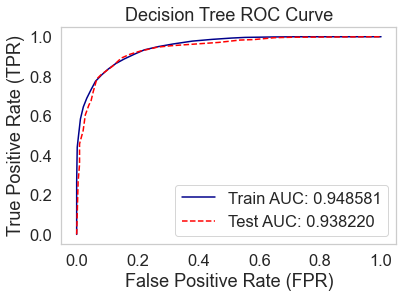

In [92]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

In [93]:

from sklearn.naive_bayes import MultinomialNB

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

mnb = MultinomialNB(alpha=0.0009)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

mnb = mnb.fit(X_train, y_train)
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))
print("Training Precision: %.5f" %precision_score(y_train,y_pred_train))
print("Testing Precision: %.5f" %precision_score(y_test,y_pred_test))
print("Training Recall: %.5f" %recall_score(y_train,y_pred_train))
print("Training Recall: %.5f" %recall_score(y_test,y_pred_test))

Trainig Accuracy: 0.67859
Test Accuracy: 0.69762
Training Precision: 0.59386
Testing Precision: 0.62597
Training Recall: 0.96239
Training Recall: 0.97122


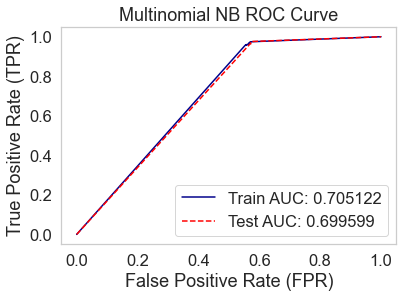

In [94]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = mnb.predict_proba(X_train)
scores_test = mnb.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_mnb_train, tpr_mnb_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_mnb_test, tpr_mnb_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_mnb_train, tpr_mnb_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.plot(fpr_mnb_test, tpr_mnb_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.title("Multinomial NB ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

In [95]:
from sklearn.ensemble import RandomForestClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))
print("Training Precision: %.5f" %precision_score(y_train,y_pred_train))
print("Testing Precision: %.5f" %precision_score(y_test,y_pred_test))
print("Training Recall: %.5f" %recall_score(y_train,y_pred_train))
print("Training Recall: %.5f" %recall_score(y_test,y_pred_test))

Trainig Accuracy: 0.85232
Test Accuracy: 0.84524
Training Precision: 0.87093
Testing Precision: 0.88064
Training Recall: 0.79867
Training Recall: 0.79616


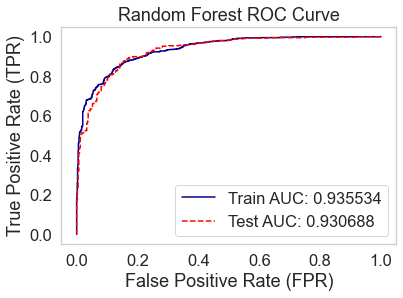

In [96]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

In [97]:
from xgboost import XGBClassifier


X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
model = XGBClassifier()
model.fit(X_train, y_train)
#model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, learning_rate = 0.05, n_estimators = 5000, early_stopping_rounds = 10)
#model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))
print("Training Precision: %.5f" %precision_score(y_train,y_pred_train))
print("Testing Precision: %.5f" %precision_score(y_test,y_pred_test))
print("Training Recall: %.5f" %recall_score(y_train,y_pred_train))
print("Training Recall: %.5f" %recall_score(y_test,y_pred_test))

Trainig Accuracy: 0.98808
Test Accuracy: 0.83571
Training Precision: 0.99230
Testing Precision: 0.84559
Training Recall: 0.98222
Training Recall: 0.82143


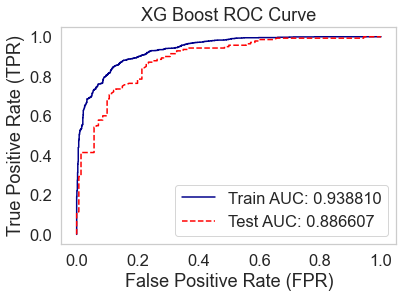

In [98]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("XG Boost ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

In [99]:
estimators = []

#5 decision tree models

model1 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)
estimators.append(('entropy1',model1))
model2 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=40, min_samples_split=7)
estimators.append(('entropy2',model2))
model3 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20, min_samples_split=4)
estimators.append(('entropy3',model3))
model4 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=80, min_samples_split=15)
estimators.append(('entropy4',model4))
model5 = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=10)
estimators.append(('entropy5',model5))

#5 mnb
model6 = MultinomialNB(alpha=0.0009)
estimators.append(('nb1',model6))

model7 = MultinomialNB(alpha=0.01)
estimators.append(('nb2',model7))

model8 = MultinomialNB(alpha=0.1)
estimators.append(('nb3',model8))

model9 = MultinomialNB(alpha=0.009)
estimators.append(('nb4',model9))

model10 = MultinomialNB(alpha=0.9)
estimators.append(('nb5',model10))

#random foorest

model11 = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)
estimators.append(('rf1',model11))

model12 = RandomForestClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=16)
estimators.append(('rf2',model12))

model13 = RandomForestClassifier(criterion='entropy', min_samples_leaf=75, min_samples_split=20)
estimators.append(('rf3',model13))

model14 = RandomForestClassifier(criterion='entropy', min_samples_leaf=25, min_samples_split=5)
estimators.append(('rf4',model14))

model15 = RandomForestClassifier(criterion='entropy', min_samples_leaf=150, min_samples_split=30)
estimators.append(('rf5',model15))


#xgb
model16 = XGBClassifier()
estimators.append(('xg1',model16))

model17 = XGBClassifier()
estimators.append(('xg2',model17))

model18 = XGBClassifier()
estimators.append(('xg3',model18))

model19 = XGBClassifier()
estimators.append(('xg4',model19))

model20 = XGBClassifier()
estimators.append(('xg5',model20))



ensemble = VotingClassifier(estimators)
ensemble.fit(X, y)
y_pred_train = ensemble.predict(X_train)
y_pred_test = ensemble.predict(X_test)
predictions = ensemble.predict(X)
prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))
print("Training Precision: %.5f" %precision_score(y_train,y_pred_train))
print("Testing Precision: %.5f" %precision_score(y_test,y_pred_test))
print("Training Recall: %.5f" %recall_score(y_train,y_pred_train))
print("Training Recall: %.5f" %recall_score(y_test,y_pred_test))

Trainig Accuracy: 0.92372
Test Accuracy: 0.90000
Training Precision: 0.91174
Testing Precision: 0.88889
Training Recall: 0.92718
Training Recall: 0.91429


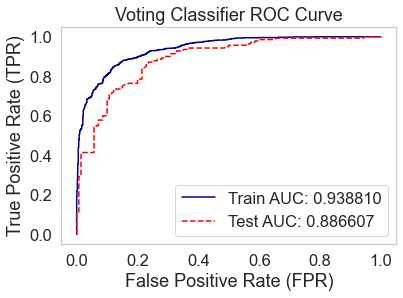

In [100]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Voting Classifier ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

In [101]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

filepath = '/Users/devanshibhatia/Desktop/PROJECT/FINALPROJECT/FinalProjectAndCode/kaggle_data/'
file= filepath+'training_data_2_csv_UTF.csv'

training_data = pd.read_csv(file)

In [102]:
def isNaN(string):
    return string != string
# remove the hashtags, mentions and unwanted characters.
def clean_text(tweets_list):
#     print(df[text_field])
#     print(df[text_field])
    #df[text_field] = df[text_field].str.lower()
    
#     tweets_list = tweets_list.replace(np.nan, '', regex=True)
#     tweets_list = tweets_list.apply(lambda d: '' if math.isnan(d) else d)
#     tweets_list = []
#     print(df[text_field])
    #y = ""
    if len(tweets_list) == 0:
        return []
    for i in range(0,len(tweets_list)):
        if isNaN(tweets_list[i]):
            tweets_list[i] =''
        if(tweets_list[i][0] == 'R'):
            if len(tweets_list[i])>1 and tweets_list[i][1] == 'T':
                tweets_list[i]=''
        y = tweets_list[i]
        y = y.lower()
       # y = y.replace(np.nan, '', regex=True)
        y = re.sub('[^A-Za-z0-9 ]+', '', y)
        y = y.replace("@", "")
        y = y.replace("n\'t", " not")
        #remove links
        y = re.sub(r"http\S+", "", y)
        #remove words less than 2
        y = re.sub(r'\b\w{1,2}\b', '', y)

        #Lowercase
        y = y.lower()
        #print(y)
        tweets_list[i] = y
    #tweets_list = ' '.join(tweets_list).split()
#     for i in range(len(tweets_list)):
#         if tweets_list[i]=='' or tweets_list[i] == ' ':
#             tweets_list.remove(tweets_list[i])
#             i-=2
    tweets_list = [i for i in tweets_list if i]       
    return tweets_list
    #tweets_list[:] = [x for x in tweets_list if x]
    #tweets_list = list(filter(None, tweets_list)) 
        #words = y.split()
        #x.append(words)
    #df[text_field] = df[text_field].apply(lambda elem:re.sub(('@[A-Za-z0–9]+)|([⁰-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?','',elem)) 
    #print(tweets_list)
#return df
#tweets_list= clean_text(d)
#print((tweets_list))



In [103]:
nlp = en_core_web_sm.load() 
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation) #already taken care of with the cleaning function.
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()
def furnished(text):
    final_text = []
    word = ""
    #print(text)
    #print(type(text))
    #print(w_tokenizer.tokenize(text))
    for i in w_tokenizer.tokenize(text):
        #print(i)
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
        final_text.append(word.lower())
    return (final_text)
'''
for i in tweets_list:
    i = furnished(i)
print(tweets_list)
'''

'\nfor i in tweets_list:\n    i = furnished(i)\nprint(tweets_list)\n'

In [104]:
def Jaccard_Similarity(doc1, doc2): 
    
    # List the unique words in a document
    words_doc1 = set(doc1) 
    words_doc2 = set(doc2)
    
    # Find the intersection of words list of doc1 & doc2
    intersection = words_doc1.intersection(words_doc2)

    # Find the union of words list of doc1 & doc2
    union = words_doc1.union(words_doc2)
    if len(union) is not 0 :   
    # Calculate Jaccard similarity score 
    # using length of intersection set divided by length of union set
        return float(len(intersection)) / len(union)
    else :
        return 0

In [105]:
def cal_jaccard(tweets_list) :
    minn = 2
    maxx = -1
    summ = 0
    tott = 0
    if tweets_list is [] or tweets_list is None:
        return -1
    for i in range(0,len(tweets_list)):
        for j in range(i+1,len(tweets_list)):
            jc = Jaccard_Similarity(tweets_list[i],tweets_list[j])
            if jc < minn :
                minn = jc
            if jc > maxx :
                maxx = jc
            summ += jc
            tott += 1
#         print(Jaccard_Similarity(tweets_list[i],tweets_list[j]))
    if tott != 0 :
        return (summ/tott)
    else:
        return -1
    #print(minn)
    #print(maxx)

In [114]:
import tweepy 
import csv
import ast
  
consumer_key = "H05K8rkSvdBTpMT3ZC7eywPiL" 
consumer_secret = "WsVOe5AGVfGTZ6Tyw8UlsvARVv8xJXW6veTe4C6mJmIAdtZw1j"
access_key = "1026504693076254721-28BTlMiTeq77cHgqSHRiXnc65BIRuF"
access_secret = "jYif6ZNvHzbVP2NQbNUJ3CIrm4YrwZ5M7rStT1Fxqmy7O"

filename = "data.csv"

filepath1 = '/Users/devanshibhatia/Desktop/PROJECT/FINALPROJECT/FinalProjectAndCode/IPython Notebooks/'
filename_sim= filepath1+'prediction.csv'
hyb_pred_file= pd.read_csv(filename_sim)
training_data = pd.read_csv(file)

def user_details(username):

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
   
    auth.set_access_token(access_key, access_secret) 
   
    api = tweepy.API(auth)

    user = api.get_user(username)
    # print(user._json)

    user_dict = {}
    temp_dict = {}
    temp_dict.update({'followers_count': user._json['followers_count']})
    temp_dict.update({'friends_count': user._json['friends_count']})
    temp_dict.update({'created_at': user._json['created_at']})
    temp_dict.update({'verified': user._json['verified']})
    user_dict.update({'name':username})
    user_dict.update({'info':temp_dict})
    tweets = get_tweets(username)
    user_dict.update({'tweets': tweets})
    # ast.literal_eval(user_dict)
    
    fields = ['name','info','tweets']
    
    with open('data.csv', 'a+', newline='') as f:
        for key in user_dict.keys():
            f.write("%s,%s\n"%(key,user_dict[key]))

    print(user_dict)
  

def get_tweets(username): 
           
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
   
    auth.set_access_token(access_key, access_secret) 
   
    api = tweepy.API(auth) 
  
    # 200 tweets to be extracted 
    number_of_tweets=10
    try:
        tweets = api.user_timeline(screen_name=username) 
    except:
        return 
 
    tmp=[]  
  
    tweets_for_csv = [tweet.text for tweet in tweets]   
    # print(tweets_for_csv)
    return tweets_for_csv

def get_followers(username):

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
 
    auth.set_access_token(access_key, access_secret) 
  
    api = tweepy.API(auth)

    res = []

    for follower in api.followers(username):
        res.append(follower.screen_name)
    
    return res

# Driver code 
if __name__ == '__main__': 
   
    positive =0
    negative =0
    deleted =0
    negative1=0
    positive1=0
    TP1=0
    TN1=0
    FP1=0
    FN1=0
                        
    TP=0
    TN=0
    FP=0
    FN=0
    #followers = get_followers("_all_of_us_")
    #for i in range(len(training_data)):
    index=0
    for i, row in training_data.iterrows(): 
        name = row['screen_name']
        d = get_tweets(name)
        if d is not None :
            #if len(d) != 0:
                clean_text(d)
                for i in d:
                    i = furnished(i)
                score = cal_jaccard(d)
                hyb_result = hyb_pred_file.iloc[index]['predictions']
                
                #hyb = 1 && score >0.5 
                if hyb_result=='1':
                    if score >0.4:
                        #hyb_pred_file.set_value(index, 'predictions', '1')
                        hyb_result = '1'
                    elif score<0.2:
                        #hyb_pred_file.set_value(index, 'predictions', '0')
                        hyb_result='0'
                if hyb_result=='0':
                    if score>0.8:
                        #hyb_pred_file.set_value(index, 'predictions', '1')
                        hyb_result='1'
              #  hyb_pred_file.to_csv("/Users/devanshibhatia/Desktop/PROJECT/FINALPROJECT/FinalProjectAndCode/IPython Notebooks/prediction.csv", index=False)
                if score >= 0.6:
                     score = 1.0
                else :
                     score = 0.0
                if row['bot'] == hyb_result:
                    positive1+=1
                else:
                    negative1+=1
                
                
                if hyb_result == '1':
                    if row['bot'] == 1:#TRUE POSITIVE
                        TP1+=1
                    elif row['bot'] == 0:#False positive
                        FP1+=1
                elif hyb_result == '0':
                    if row['bot'] == 0: #True negative
                        TN1+=1
                    elif row['bot'] == 1:#false negative
                        FN1+=1
                    
                    
                if row['bot'] == score :
                    positive+=1
                else:
                    negative+=1

                
                if score == 1.0:
                    if row['bot'] == 1:#TRUE POSITIVE
                        TP+=1
                    elif row['bot'] == 0:#False positive
                        FP+=1
                elif score == 0.0:
                    if row['bot'] == 0: #True negative
                        TN+=1
                    elif row['bot'] == 1:#false negative
                        FN+=1
            #else :
             #   notweet+=1
        else:
            deleted+=1
            
        index+=1
        
        
    length = (len(training_data) - deleted)
    accuracy = positive/length
    accuracy1 = positive1/length
    print(accuracy)
    print(accuracy1)        
    
   # print(type(d))
    # for follower in followers:
    #     print(follower)
    #     user_details(follower)
    #     get_tweets(follower)  

0.6998158379373849
0.9295580110497238


In [115]:
PRECISION_FINAL = TP1/(TP1+FP1)
RECALL_FINAL = TP1/(TP1+FN1)
PRECISION_SIM = TP/(TP+FP)
RECALL_SIM = TP/(TP+FN)


ZeroDivisionError: division by zero

In [ ]:
print("Similarity Precision: %.5f" %PRECISION_SIM)
print("Similarity Recall: %.5f" %RECALL_SIM)
print("Final Precision: %.5f" %PRECISION_FINAL)
print("Final Recall: %.5f" %RECALL_FINAL)

In [113]:
print(FP1,TP)
dele = deleted/len(training_data)
print(type(training_data['bot'][0]))
print(dele)

0 0
<class 'numpy.int64'>
0.22702895959957098
